## Prep

In [3]:
##### import packages
#base
import os
import sys
from collections import defaultdict
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import random
import pyreadr
import pandas as pd
import seaborn as sns
%matplotlib inline
%autosave 30

#pyro contingency
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Predictive
from pyro.ops.indexing import Vindex
from pyro.infer import MCMC, NUTS
import torch
from torch.distributions import constraints
pyro.enable_validation(True)

#misc
import pickle
import torch.nn.functional as F
import itertools
import time
# import umap
# import plotly
# import plotly.graph_objs as go

# import homebrew modules
import models.tomtom_models as tm
import models.tomtom_util as tu

# some useless warnings from seaborn, suppressing here
import warnings
warnings.filterwarnings("ignore")

C:\Users\zhaoz\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Autosaving every 30 seconds


In [4]:
# import data and previously fitted parameters
# import pickled data
with open('data/tomtom_data_preprocessed.pkl','rb') as f:
    [tself_norm_all_3d, tself_norm_noauto_3d, tself_raw_all_3d, tself_raw_noauto_3d,
    ttarg_norm_all_3d, ttarg_norm_noauto_3d, ttarg_raw_all_3d, ttarg_raw_noauto_3d,
    tavg_norm_all_3d, tavg_norm_noauto_3d, tavg_raw_all_3d, tavg_raw_noauto_3d] = pickle.load(f)
# import fitted models from the varying-k analyses
with open('tomtom_fitted_models.pkl','rb') as f:
    [seeds_self_norm_all_grp,maps_self_norm_all_grp,logprobs_self_norm_all_grp,mems_self_norm_all_grp,
     seeds_self_norm_all_dim,maps_self_norm_all_dim,logprobs_self_norm_all_dim,
     seeds_self_norm_noauto_grp,maps_self_norm_noauto_grp,logprobs_self_norm_noauto_grp,mems_self_norm_noauto_grp,
     seeds_self_norm_noauto_dim,maps_self_norm_noauto_dim,logprobs_self_norm_noauto_dim,
     seeds_self_raw_all_grp,maps_self_raw_all_grp,logprobs_self_raw_all_grp,mems_self_raw_all_grp,
     seeds_self_raw_all_dim,maps_self_raw_all_dim,logprobs_self_raw_all_dim,
     seeds_self_raw_noauto_grp,maps_self_raw_noauto_grp,logprobs_self_raw_noauto_grp,mems_self_raw_noauto_grp,
     seeds_self_raw_noauto_dim,maps_self_raw_noauto_dim,logprobs_self_raw_noauto_dim] = pickle.load(f)

## Data generation

In [4]:
# code to generate data from params
# define separate functions for group model and dimension model
#  group
def datagen_grp(n_sample, map_est):
    # initialize storage
    stor = []
    if 'concentration' in map_est.keys():
        for i in np.arange(n_sample):
            grp = dist.Categorical(map_est['weights']).sample()
            grp_c = map_est['concentration'][grp]
            samp = dist.Dirichlet(grp_c).sample()
            stor.append(samp)
    else:
        for i in np.arange(n_sample):
            grp = dist.Categorical(map_est['weights']).sample()
            grp_a = map_est['alpha'][grp]
            grp_b = map_est['beta'][grp]
            samp = dist.Beta(grp_a, grp_b).sample()
            stor.append(samp)
    return torch.stack(stor)

# # short function to add N empty dimensions to a tensor
# def add_n_dim(t,n):
#     for i in np.arange(n):
#         t = t[:,None]
#     return t

#  dimension
def datagen_dim(n_sample, map_est):
    stor = []
    if 'topic_concentration' in map_est.keys():
        for i in np.arange(n_sample):
            # sample participant level topic weights
            p_w = dist.Dirichlet(map_est['topic_weights']).sample()
            # component matrices
            c_m = dist.Dirichlet(map_est['topic_concentration']).sample()
            # normalize components with participant weights
            c_m_weighted = p_w[:,None,None] * c_m # make broadcasting work
            weighted_mixture = c_m_weighted.sum(0)
            stor.append(weighted_mixture)
    else:
        for i in np.arange(n_sample):
            # sample participant level topic weights
            p_w = dist.Dirichlet(map_est['topic_weights']).sample()
            # component matrices
            c_m = dist.Beta(map_est['topic_a'], map_est['topic_b']).sample()
            # normalize components with participant weights
            c_m_weighted = p_w[:,None,None] * c_m # make broadcasting work
            weighted_mixture = c_m_weighted.sum(0)
            stor.append(weighted_mixture)
    return torch.stack(stor)

In [17]:
# actually generating new data
## varying along: K, n_sample
## for each combo of the two repeat 20
n_repeat = 2
n_sample_array = np.concatenate((np.arange(10,210,10), np.arange(300,1100,100)))
# n_sample_array = np.arange(10,30,10)
# wrap in a function so this can be done for maps from different fitted model params
# takes in an array of MAPs, model type ('grp'/'dim'),n repeat, all values of n_sample
# return nested list
    # l1 organized by K (index+1)
    # l2 organize by n_sample_array
    # l3 are tensors: n repeat * n_sample * data_dimensions
def datagen_combo(maps, mtype, n_repeat, n_sample_array):
    stor1 = []
    for mmap in maps:
        stor2 = []
        for n_sample in n_sample_array:
            stor3 = []
            for i in np.arange(n_repeat):
                if mtype == 'grp':
                    dat = datagen_grp(n_sample, mmap)
                elif mtype == 'dim':
                    dat = datagen_dim(n_sample, mmap)
#                 print(dat.shape)
                stor3.append(dat)
#             print(torch.stack(stor3).shape)
            stor2.append(torch.stack(stor3))
        stor1.append(stor2)
    return stor1

random.seed(20201103)
gendat_self_norm_all_grp = datagen_combo(maps_self_norm_all_grp, 'grp', n_repeat, n_sample_array)
gendat_self_norm_all_dim = datagen_combo(maps_self_norm_all_dim, 'dim', n_repeat, n_sample_array)
gendat_self_raw_noauto_grp = datagen_combo(maps_self_raw_noauto_grp, 'grp', n_repeat, n_sample_array)
gendat_self_raw_noauto_dim = datagen_combo(maps_self_raw_noauto_dim, 'dim', n_repeat, n_sample_array)



NameError: name 'datagen_grp' is not defined

In [ ]:
# # pickle generated data
# with open('model_recovery_gen_dat.pkl','wb') as f:
#     pickle.dump([gendat_self_norm_all_grp,gendat_self_norm_all_dim,
#                 gendat_self_raw_noauto_agrp,gendat_self_raw_noauto_dim],f)

In [4]:
# load previously generated data
with open('model_recovery_gen_dat.pkl','rb') as f:
    [gendat_self_norm_all_grp,gendat_self_norm_all_dim,
    gendat_self_raw_noauto_grp,gendat_self_raw_noauto_dim] = pickle.load(f)

MemoryError: 

## Refitting the models
### The refitting was done on cluster, see separate scripts

## Evaluating refitted parameters

In [5]:
# code to summarize param recovery
# first read in the refitted paramter files
def read_refit_cross_param(norm,auto,mtype):
    seeds = []
    maps = []
    logprobs = []
    maxk = 10
    for i in np.arange(maxk):
        fname = 'modrec_self_{}_{}_{}_cross_k{}.pkl'.format(norm,auto,mtype,i)
        with open(fname, 'rb') as f:
            [sk,mk,lpk] = pickle.load(f)
        seeds.append(sk)
        maps.append(mk)
        logprobs.append(lpk)
        print('done reading from {}'.format(fname))
    return seeds, maps, logprobs

In [6]:
seeds_self_norm_all_dim_refit_cross, maps_self_norm_all_dim_refit_cross, logprobs_self_norm_all_dim_refit_cross = \
read_refit_cross_param('norm','all','dim')
seeds_self_norm_all_grp_refit_cross, maps_self_norm_all_grp_refit_cross, logprobs_self_norm_all_grp_refit_cross = \
read_refit_cross_param('norm','all','grp')
seeds_self_raw_noauto_grp_refit_cross, maps_self_raw_noauto_grp_refit_cross, logprobs_self_raw_noauto_grp_refit_cross = \
read_refit_cross_param('raw','noauto','grp')
seeds_self_raw_noauto_dim_refit_cross, maps_self_raw_noauto_dim_refit_cross, logprobs_self_raw_noauto_dim_refit_cross = \
read_refit_cross_param('raw','noauto','dim')

done reading from modrec_self_norm_all_dim_cross_k0.pkl
done reading from modrec_self_norm_all_dim_cross_k1.pkl
done reading from modrec_self_norm_all_dim_cross_k2.pkl
done reading from modrec_self_norm_all_dim_cross_k3.pkl
done reading from modrec_self_norm_all_dim_cross_k4.pkl
done reading from modrec_self_norm_all_dim_cross_k5.pkl
done reading from modrec_self_norm_all_dim_cross_k6.pkl
done reading from modrec_self_norm_all_dim_cross_k7.pkl
done reading from modrec_self_norm_all_dim_cross_k8.pkl
done reading from modrec_self_norm_all_dim_cross_k9.pkl
done reading from modrec_self_norm_all_grp_cross_k0.pkl
done reading from modrec_self_norm_all_grp_cross_k1.pkl
done reading from modrec_self_norm_all_grp_cross_k2.pkl
done reading from modrec_self_norm_all_grp_cross_k3.pkl
done reading from modrec_self_norm_all_grp_cross_k4.pkl
done reading from modrec_self_norm_all_grp_cross_k5.pkl
done reading from modrec_self_norm_all_grp_cross_k6.pkl
done reading from modrec_self_norm_all_grp_cross

### Looking at parameter correlation,  only corresponding Ks

### Data K model K crossed - graphing log prob

In [7]:
# convert list of log probs into a long format dataframe
n_sample_array = np.concatenate((np.arange(10,160,15), np.arange(200,600,100)))
def logprobs_ls2df_cross(ls):
    maxk = 10
    stor = []
    for nsind in np.arange(len(n_sample_array)):
       stor.append(torch.cat([torch.stack([torch.stack(modelk[nsind]).mean() for modelk in datak]) for datak in ls]))
    logprobs = torch.cat(stor)
    nsample = np.repeat(n_sample_array,maxk*maxk)
    modelk = np.tile(np.arange(maxk)+1,maxk*len(n_sample_array))
    datak = np.tile(np.repeat(np.arange(maxk)+1,maxk),len(n_sample_array))
    datanp = np.stack([logprobs,modelk,datak,nsample]).transpose()
    return pd.DataFrame(data = datanp, columns=['logprobs','modelk','datak','nsample'])
    

In [13]:
lpdf_self_norm_all_grp_refit_cross = logprobs_ls2df_cross(logprobs_self_norm_all_grp_refit_cross)
lpdf_self_norm_all_dim_refit_cross = logprobs_ls2df_cross(logprobs_self_norm_all_dim_refit_cross)
lpdf_self_raw_noauto_grp_refit_cross = logprobs_ls2df_cross(logprobs_self_raw_noauto_grp_refit_cross)
lpdf_self_raw_noauto_dim_refit_cross = logprobs_ls2df_cross(logprobs_self_raw_noauto_dim_refit_cross)

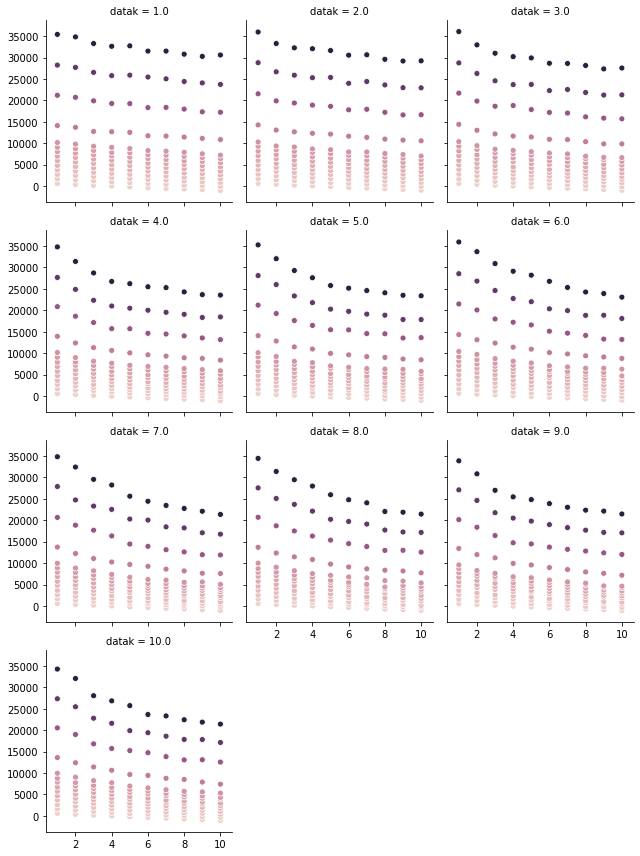

In [10]:
# norm all grp
g = sns.FacetGrid(lpdf_self_norm_all_grp_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

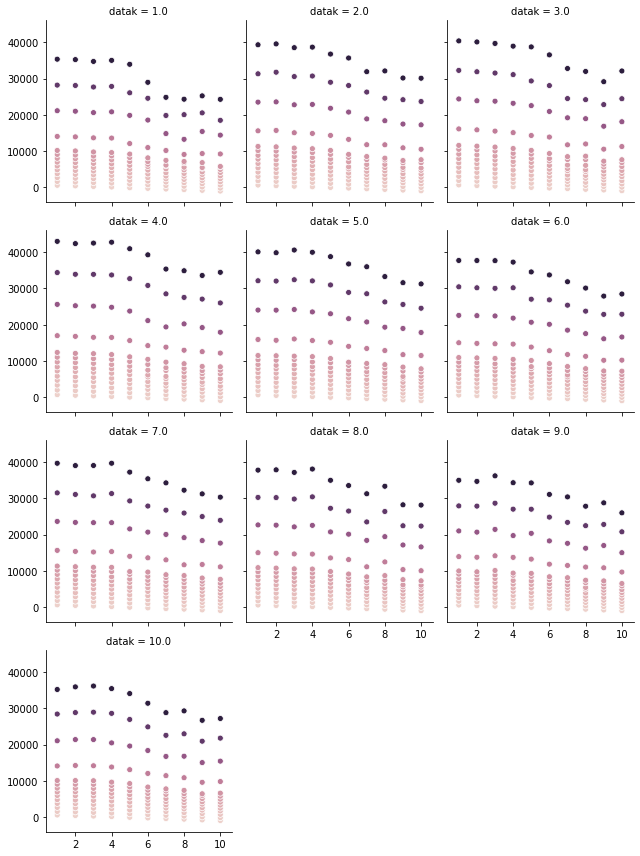

In [11]:
# norm all dim
g = sns.FacetGrid(lpdf_self_norm_all_dim_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

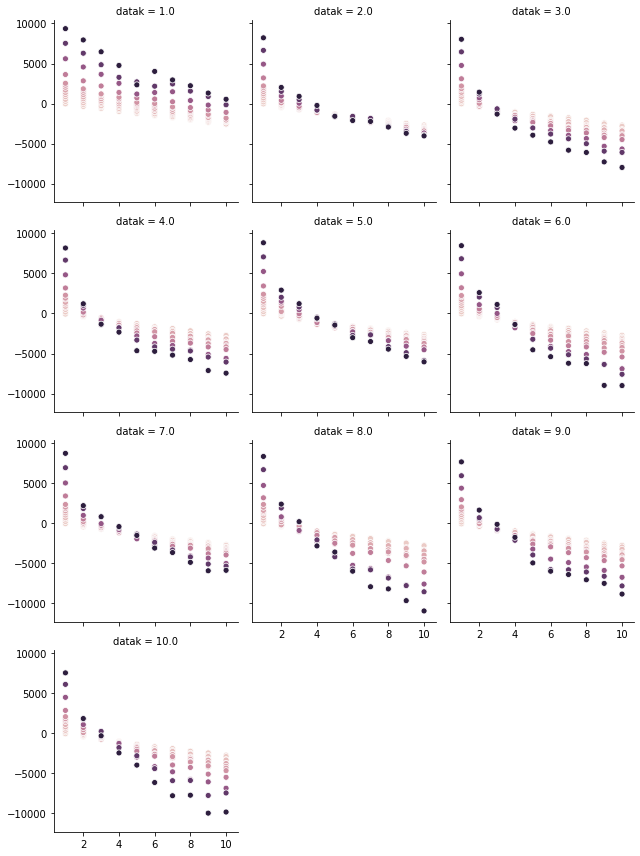

In [14]:
# raw noauto grp
g = sns.FacetGrid(lpdf_self_raw_noauto_grp_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')

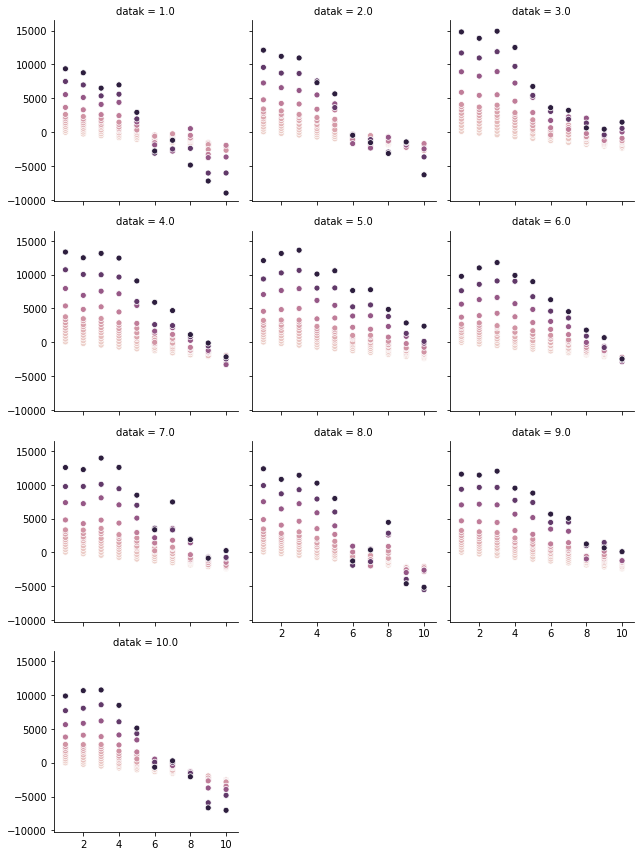

In [15]:
# raw noauto dim
g = sns.FacetGrid(lpdf_self_raw_noauto_dim_refit_cross, col = 'datak',col_wrap = 3)
g.map_dataframe(sns.scatterplot, x = 'modelk', y = 'logprobs', hue = 'nsample')